# Introduction to swyft-lightning

In this notebook, we will go through the basic steps of performing parameter inference with swyft.

## Setup

First we need some imports.

In [52]:
import pylab as plt
import numpy as np
from scipy import stats
import torch
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

with $z \sim \mathcal{N}(\mu = 0, \sigma^2 = 1)$ standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma^2 = 0.01)$ is some noise term.  We will infer the posterior for $z$ given a measurement of parameter $x$.

In [53]:
N = 3500  # Number of samples
z = np.random.randn(N, 1)
x = z + np.random.randn(N, 1)*0.1
z, x = swyft.to_numpy32((z, x))  # Convenience function to convert to single precision

Training data in memory is stored in a `swyft.Samples` object.

In [54]:
samples = swyft.Samples(x = x, z = z)

The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [55]:
dl_train = samples[:3000].get_dataloader(batch_size = 32, shuffle = True)
dl_valid = samples[3000:3500].get_dataloader(batch_size = 32)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.RatioEstimatorMLP1d`, for mapping $x$ and $z$ onto a ratio estimator object.

In [58]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.classifier = swyft.RatioEstimatorMLP1d(x_dim = 1, z_dim = 1)

    def forward(self, A, B):
        ratios = self.classifier(A['x'], B['z'])
        return dict(z = ratios)

In [59]:
network = Network()

## Trainer

Training is now done using the `SwyftTrainer` class, which essentially corresponds to `pl.Trainer`, extended with a few convenience methods.

In [60]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [61]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLP1d | 17.4 K
---------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9819912/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  85%|████████▌ | 94/110 [00:00<00:00, 100.36it/s, loss=-0.968, v_num=9819912]
Validating: 0it [00:00, ?it/s]
Epoch 1:  85%|████████▌ | 94/110 [00:00<00:00, 99.31it/s, loss=-0.965, v_num=9819912, val_loss=-.952]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|████████▌ | 94/110 [00:00<00:00, 102.01it/s, loss=-0.96, v_num=9819912, val_loss=-.935]  
Validating: 0it [00:00, ?it/s]
Epoch 3:  85%|████████▌ | 94/110 [00:00<00:00, 102.15it/s, loss=-1.02, v_num=9819912, val_loss=-.930] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  85%|████████▌ | 94/110 [00:00<00:00, 100.69it/s, loss=-0.956, v_num=9819912, val_loss=-.976]
Validating: 0it [00:00, ?it/s]
Epoch 5:  85%|████████▌ | 94/110 [00:00<00:00, 99.25it/s, loss=-0.963, v_num=9819912, val_loss=-.964]  
Validating: 0it [00:00, ?it/s]
Epoch 6:  85%|████████▌ | 94/110 [00:00<00:00, 97.15it/s, loss=-0.901, v_num=9819912, val_loss=-.965]  
Validating: 0it [00:00, ?it/s]
Epoch 7:  85%|████████▌ | 94/110 [00:00<00:00, 97.00it/s, loss=-1, v_num=9

## Inference

We assume that we measure the values $x=0.5$.

In [76]:
x0 = 0.2

We first generate a large number of prior samples.

In [77]:
prior_samples = swyft.Samples(dict(z = swyft.to_numpy32(np.random.randn(100000, 1))))

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates| the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [78]:
predictions = trainer.infer(network, swyft.Sample(x = torch.zeros(1)+x0), prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 100%|██████████| 98/98 [00:00<00:00,  8.10it/s]


## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

In [79]:
post_samples = predictions.sample(100000)

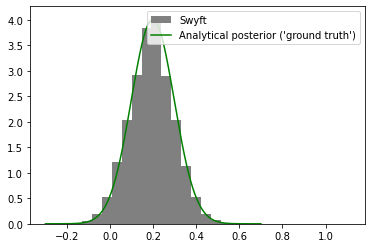

In [80]:
# Plot swyft results
plt.hist(post_samples['z'][:,0].numpy(), bins = 30, density = True, color = '0.5', label = "Swyft");

# Compare with analytical result
xn = np.linspace(x0-0.5, x0+0.5, 1000)
sigma_eff = (1/0.1**2 + 1/1**2)**-0.5
mu_eff = x0/(1**2 + 0.1**2)
yn = stats.norm.pdf(xn, mu_eff, sigma_eff)
plt.plot(xn, yn, 'g', label = "Analytical posterior ('ground truth')")
plt.legend(loc=1)